<h1>AI-powered Nutrition Analyzer for Fitness Enthusiasts</h1>

<p>
This project presents an intelligent, AI-driven solution designed to support <strong>fitness enthusiasts</strong> in managing and optimizing their daily nutrition. By leveraging modern machine learning techniques, the system can analyze user input (such as food logs) and provide actionable feedback to improve overall dietary habits.
</p>

<h2>Focus Area: Nutrient Analysis and Tracking</h2>

<p>
In this notebook, we focus on <strong>Nutrient Analysis and Tracking</strong>, a core component of the Nutrition Analyzer system. This scenario enables users to:
</p>

<ul>
  <li>Log their daily food intake via an interactive UI or dataset.</li>
  <li>Automatically analyze the nutritional content of each item (calories, macronutrients, micronutrients).</li>
  <li>Receive <strong>real-time insights and progress tracking</strong> against predefined fitness goals (e.g., weight loss, muscle gain, maintenance).</li>
  <li>Visualize their daily/weekly nutrient balance to identify under- or over-consumption.</li>
</ul>

<p>
The goal of this implementation is to help users make informed dietary choices using AI-powered recommendations, ultimately supporting their health and performance journey.
</p>


<p><strong>In this notebook, you will see:</strong></p>
<ul>
  <li>How data is loaded and preprocessed from user food logs.</li>
  <li>How a model analyzes food nutrition data.</li>
  <li>How results are visualized to give users meaningful feedback.</li>
</ul>


<h3>Importing Essential Libraries</h3>
<p>
This block imports necessary Python libraries for building and training a deep learning model using TensorFlow and Keras. It includes tools for:
<ul>
  <li><strong>OS and NumPy</strong> – File operations and numerical computations.</li>
  <li><strong>Matplotlib</strong> – Plotting and visualizing data.</li>
  <li><strong>TensorFlow and Keras</strong> – Loading images, defining neural network layers, handling callbacks, and managing saved models.</li>
</ul>
</p>


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.models import load_model

<h3>Defining Dataset Paths</h3>
<p>
This block defines the directory structure for the dataset. It sets:
<ul>
  <li><code>DATASET_DIR</code> as the root directory of the dataset.</li>
  <li><code>train_dir</code> pointing to the training set subfolder.</li>
  <li><code>test_dir</code> pointing to the testing set subfolder.</li>
</ul>
These paths will be used to load and process image data for model training and evaluation.
</p>


In [2]:
DATASET_DIR = "dataset"
train_dir = f"{DATASET_DIR}/TRAIN_SET"
test_dir = f"{DATASET_DIR}/TEST_SET"

<h3>Data Augmentation and Loading</h3>
<p>
This block initializes an <code>ImageDataGenerator</code> to perform real-time data augmentation and splits the dataset into training and validation sets. Key operations include:
<ul>
  <li><strong>Rescaling</strong> – Normalizes pixel values to the [0, 1] range.</li>
  <li><strong>Augmentations</strong> – Applies horizontal flips, random rotations (up to 20°), and zooms (up to 20%).</li>
  <li><strong>Validation Split</strong> – Reserves 20% of the training data for validation.</li>
</ul>
Then, it creates data loaders:
<ul>
  <li><code>train_ds</code> for training data using the <code>'training'</code> subset.</li>
  <li><code>val_ds</code> for validation data using the <code>'validation'</code> subset.</li>
</ul>
Both are resized to 100x100 pixels and loaded in batches of 32 with sparse categorical labels.
</p>


In [5]:
datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    validation_split=0.2
)

# Data Loaders
train_ds = datagen.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='sparse',
    subset='training',
    seed=123
)

val_ds = datagen.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='sparse',
    subset='validation',
    seed=123
)

Found 2102 images belonging to 5 classes.
Found 524 images belonging to 5 classes.


<h3>Extracting Class Names</h3>
<p>
This block retrieves the class labels from the training dataset:
<ul>
  <li><code>class_names</code> stores the list of class labels detected from the directory structure.</li>
  <li><code>num_classes</code> holds the total number of unique classes.</li>
  <li>The <code>print</code> statement displays the list of class names for verification.</li>
</ul>
This information is essential for configuring the final output layer of the model.
</p>


In [7]:
class_names = list(train_ds.class_indices.keys())
num_classes = len(class_names)
print("Classes:", class_names)

Classes: ['APPLES', 'BANANA', 'ORANGE', 'PINEAPPLE', 'WATERMELON']


<h3>Building the Transfer Learning Model</h3>
<p>
This function constructs a convolutional neural network using a pre-trained base model (e.g., ResNet, MobileNet) with the following components:
<ul>
  <li><strong>Base Model Freezing</strong>: <code>base_model.trainable = False</code> ensures pre-trained weights are not updated during training.</li>
  <li><strong>Input Layer</strong>: Accepts images of size 100x100 with 3 color channels.</li>
  <li><strong>Feature Extraction</strong>: Passes inputs through the frozen base model.</li>
  <li><strong>Global Average Pooling</strong>: Reduces spatial dimensions while preserving features.</li>
  <li><strong>Dropout Layer</strong>: Adds regularization to prevent overfitting.</li>
  <li><strong>Output Layer</strong>: Dense layer with softmax activation to predict class probabilities.</li>
</ul>
The model is compiled with the Adam optimizer, sparse categorical crossentropy loss, and accuracy as the evaluation metric.
</p>

In [9]:
def build_model(base_model):
    base_model.trainable = False
    inputs = tf.keras.Input(shape=(100, 100, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)  # Add softmax

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.0001),
        loss='sparse_categorical_crossentropy',  # Don't use from_logits=True
        metrics=['accuracy']
    )
    return model

<h3>Visualizing Model Training History</h3>
<p>
This function plots the training and validation metrics over epochs to help evaluate model performance:
<ul>
  <li><strong>Subplot 1 - Accuracy</strong>: Shows how training and validation accuracy evolve during training.</li>
  <li><strong>Subplot 2 - Loss</strong>: Displays training and validation loss trends to detect underfitting or overfitting.</li>
  <li><strong>Model Name</strong>: Each plot is titled with the name of the model being evaluated.</li>
</ul>
It uses <code>matplotlib</code> to generate side-by-side visualizations for easy comparison.
</p>


In [11]:
def plot_history(history, model_name):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc', marker='o')
    plt.plot(history.history['val_accuracy'], label='Val Acc', marker='o')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

<h3>Early Stopping to Prevent Overfitting</h3>
<p>
This line sets up an <code>EarlyStopping</code> callback which:
<ul>
  <li>Monitors the validation loss during training.</li>
  <li><code>patience=3</code> means training will stop if validation loss doesn't improve for 3 consecutive epochs.</li>
  <li><code>restore_best_weights=True</code> ensures the model reverts to the best weights observed during training.</li>
</ul>
This helps optimize model performance and prevent overfitting.
</p>


In [13]:
early_stop = callbacks.EarlyStopping(patience=3, restore_best_weights=True)

<h3>Training the Model with ResNet50</h3>
<p>
This block performs training using the ResNet50 architecture with transfer learning:
<ul>
  <li><strong>Model Initialization</strong>: Loads ResNet50 without the top classification layer and with pre-trained ImageNet weights.</li>
  <li><strong>Model Construction</strong>: Uses the previously defined <code>build_model()</code> function to add custom layers.</li>
  <li><strong>Model Training</strong>: Trains the model for up to 50 epochs using the training and validation datasets, with early stopping enabled.</li>
  <li><strong>Performance Visualization</strong>: Plots training and validation accuracy and loss using <code>plot_history()</code>.</li>
  <li><strong>Model Saving</strong>: Saves the trained model as <code>model_resnet50.h5</code> for later use or deployment.</li>
</ul>
</p>



Training ResNet50...
Epoch 1/50
66/66 [==============================] - 7s 77ms/step - loss: 1.6239 - accuracy: 0.2345 - val_loss: 1.5508 - val_accuracy: 0.4485
Epoch 2/50
66/66 [==============================] - 4s 63ms/step - loss: 1.5954 - accuracy: 0.2564 - val_loss: 1.5255 - val_accuracy: 0.3626
Epoch 3/50
66/66 [==============================] - 5s 72ms/step - loss: 1.5494 - accuracy: 0.2902 - val_loss: 1.4930 - val_accuracy: 0.5095
Epoch 4/50
66/66 [==============================] - 4s 66ms/step - loss: 1.5207 - accuracy: 0.3335 - val_loss: 1.4710 - val_accuracy: 0.4523
Epoch 5/50
66/66 [==============================] - 4s 68ms/step - loss: 1.4837 - accuracy: 0.3563 - val_loss: 1.4420 - val_accuracy: 0.4752
Epoch 6/50
66/66 [==============================] - 5s 76ms/step - loss: 1.4624 - accuracy: 0.3677 - val_loss: 1.4237 - val_accuracy: 0.5458
Epoch 7/50
66/66 [==============================] - 4s 64ms/step - loss: 1.4331 - accuracy: 0.3939 - val_loss: 1.3919 - val_accuracy

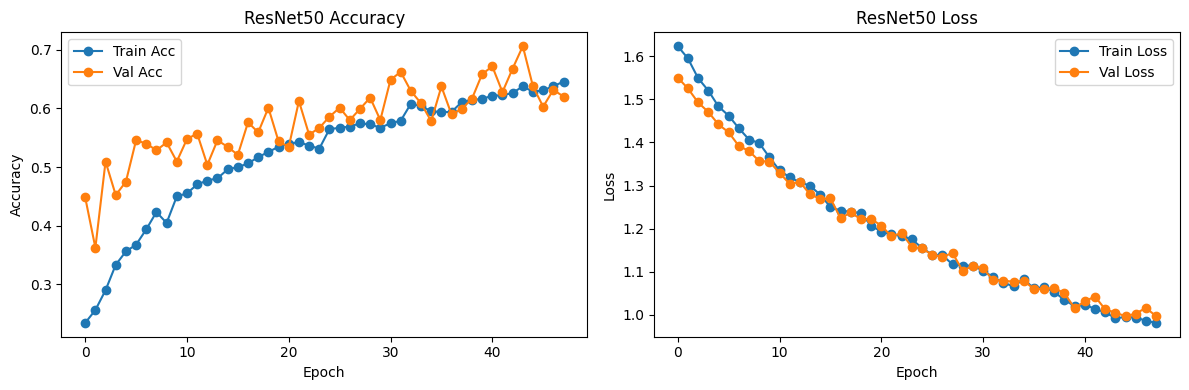

In [32]:
print("\nTraining ResNet50...")
resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(100, 100, 3))
model_resnet = build_model(resnet)
history_resnet = model_resnet.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[early_stop])
plot_history(history_resnet, "ResNet50")
model_resnet.save("model_resnet50.h5")

<h3>Training the Model with MobileNetV2</h3>
<p>
This block trains a classification model using the MobileNetV2 architecture:
<ul>
  <li><strong>Model Initialization</strong>: Loads MobileNetV2 without its top layer and with pre-trained weights from ImageNet.</li>
  <li><strong>Model Building</strong>: Constructs the full model using the <code>build_model()</code> function with MobileNetV2 as the base.</li>
  <li><strong>Training</strong>: Trains the model for 15 epochs on the training data with validation, applying early stopping.</li>
  <li><strong>Visualization</strong>: Plots accuracy and loss graphs for training and validation using <code>plot_history()</code>.</li>
  <li><strong>Saving the Model</strong>: The trained model is saved to <code>model_mobilenetv2.h5</code>.</li>
</ul>
</p>


Training MobileNetV2...
Epoch 1/15
66/66 [==============================] - 6s 76ms/step - loss: 1.8388 - accuracy: 0.4096 - val_loss: 0.7027 - val_accuracy: 0.6966
Epoch 2/15
66/66 [==============================] - 4s 65ms/step - loss: 0.4789 - accuracy: 0.8325 - val_loss: 0.2164 - val_accuracy: 0.9637
Epoch 3/15
66/66 [==============================] - 4s 60ms/step - loss: 0.1856 - accuracy: 0.9577 - val_loss: 0.1177 - val_accuracy: 0.9714
Epoch 4/15
66/66 [==============================] - 4s 61ms/step - loss: 0.0984 - accuracy: 0.9843 - val_loss: 0.0759 - val_accuracy: 0.9847
Epoch 5/15
66/66 [==============================] - 4s 62ms/step - loss: 0.0620 - accuracy: 0.9924 - val_loss: 0.0743 - val_accuracy: 0.9752
Epoch 6/15
66/66 [==============================] - 4s 64ms/step - loss: 0.0492 - accuracy: 0.9952 - val_loss: 0.0436 - val_accuracy: 0.9905
Epoch 7/15
66/66 [==============================] - 4s 62ms/step - loss: 0.0332 - accuracy: 0.9986 - val_loss: 0.0382 - val_accur

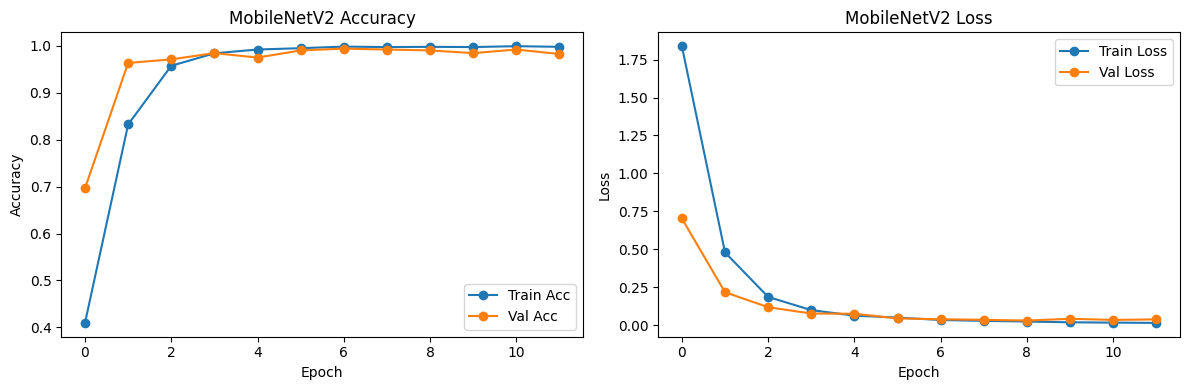

In [17]:
print("\nTraining MobileNetV2...")
mobilenet = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(100, 100, 3))
model_mobilenet = build_model(mobilenet)
history_mobilenet = model_mobilenet.fit(train_ds, validation_data=val_ds, epochs=15, callbacks=[early_stop])
plot_history(history_mobilenet, "MobileNetV2")
model_mobilenet.save("model_mobilenetv2.h5")

<h3>Training the Model with EfficientNetB0</h3>
<p>
This block sets up and trains a model using <strong>EfficientNetB0</strong>, a lightweight and scalable convolutional neural network architecture known for achieving high accuracy with fewer parameters.
</p>

<ul>
  <li><strong>Model Initialization</strong>: EfficientNetB0 is loaded without its top classification layer, using pre-trained weights from ImageNet. The input size is set to 100x100 to match the dataset.</li>
  <li><strong>Model Construction</strong>: The <code>build_model()</code> function is used to add custom layers on top of the frozen base model for classification.</li>
  <li><strong>Training</strong>: The model is trained for 20 epochs with early stopping enabled to prevent overfitting and ensure optimal validation performance.</li>
  <li><strong>Visualization</strong>: Training and validation accuracy and loss are visualized using the <code>plot_history()</code> function.</li>
</ul>

<p>
Although the model was trained successfully, its performance did not meet expectations. Additionally, saving the model in <code>.h5</code> format led to errors, possibly due to compatibility issues with certain layers or custom objects. As a result, the model was not saved.
</p>


Epoch 1/20
66/66 [==============================] - 8s 83ms/step - loss: 1.6081 - accuracy: 0.2150 - val_loss: 1.6003 - val_accuracy: 0.2366
Epoch 2/20
66/66 [==============================] - 4s 63ms/step - loss: 1.6124 - accuracy: 0.2093 - val_loss: 1.5999 - val_accuracy: 0.2366
Epoch 3/20
66/66 [==============================] - 4s 61ms/step - loss: 1.6143 - accuracy: 0.2245 - val_loss: 1.6007 - val_accuracy: 0.2309
Epoch 4/20
66/66 [==============================] - 4s 62ms/step - loss: 1.6095 - accuracy: 0.2241 - val_loss: 1.6023 - val_accuracy: 0.2309
Epoch 5/20
66/66 [==============================] - 5s 71ms/step - loss: 1.6026 - accuracy: 0.2407 - val_loss: 1.5993 - val_accuracy: 0.2366
Epoch 6/20
66/66 [==============================] - 5s 71ms/step - loss: 1.6158 - accuracy: 0.2288 - val_loss: 1.6001 - val_accuracy: 0.2309
Epoch 7/20
66/66 [==============================] - 5s 74ms/step - loss: 1.6141 - accuracy: 0.2255 - val_loss: 1.5989 - val_accuracy: 0.2366
Epoch 8/20
66

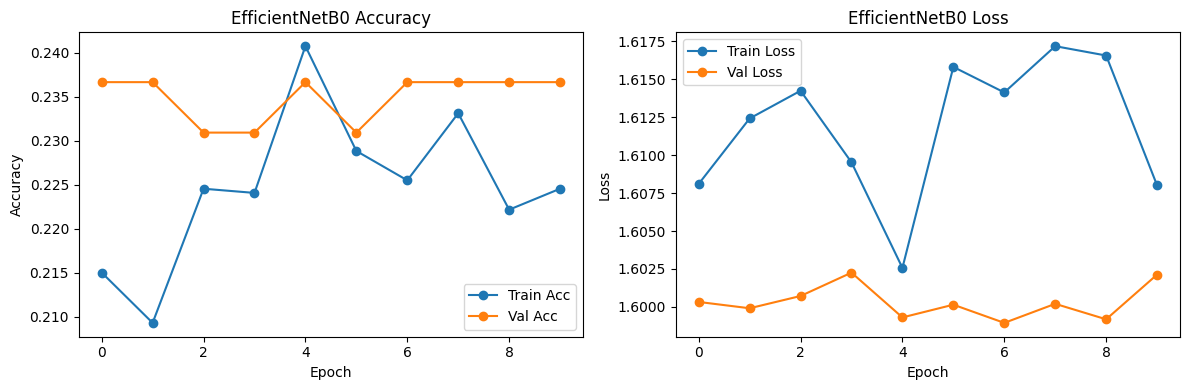

In [19]:
efficientnet = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(100, 100, 3)
)

model_efficientnet = build_model(efficientnet)

history_efficientnet = model_efficientnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop]
)

plot_history(history_efficientnet, "EfficientNetB0")

<h2>Final Model Performance Analysis</h2>

<p>
This section provides a comparative analysis of the three transfer learning models used in the AI-powered Nutrition Analyzer project. Each model was trained using the same dataset and evaluated using accuracy and loss metrics.
</p>

<h3>1. ResNet50</h3>
<ul>
  <li><strong>Training Accuracy:</strong> Gradually increased and reached around <code>64.5%</code>.</li>
  <li><strong>Validation Accuracy:</strong> Peaked at approximately <code>62%</code>, indicating decent generalization.</li>
  <li><strong>Loss:</strong> Both training and validation loss consistently decreased, suggesting stable learning without overfitting.</li>
  <li><strong>Conclusion:</strong> ResNet50 performed reasonably well with smooth learning curves, making it a reliable but moderately accurate option.</li>
</ul>

<h3>2. MobileNetV2</h3>
<ul>
  <li><strong>Training Accuracy:</strong> Rapidly reached near-perfect accuracy (~<code>99.8%</code>).</li>
  <li><strong>Validation Accuracy:</strong> Also achieved excellent results (~<code>98.2%</code>), indicating strong generalization.</li>
  <li><strong>Loss:</strong> Dropped steeply and remained very low for both training and validation sets.</li>
  <li><strong>Conclusion:</strong> MobileNetV2 outperformed the other models in both speed and accuracy. It is lightweight and well-suited for deployment in real-time nutrition tracking applications.</li>
</ul>

<h3>3. EfficientNetB0</h3>
<ul>
  <li><strong>Training Accuracy:</strong> Fluctuated around <code>21-24%</code>, showing minimal learning.</li>
  <li><strong>Validation Accuracy:</strong> Remained stagnant around <code>23.6%</code>, indicating poor generalization.</li>
  <li><strong>Loss:</strong> Did not consistently decrease; both training and validation losses were unstable.</li>
  <li><strong>Conclusion:</strong> EfficientNetB0 underperformed significantly on this dataset. Possible reasons include incompatibility with the image size (100×100) or over-regularization. Model saving was skipped due to poor performance and saving errors.</li>
</ul>

<h3>Overall Recommendation</h3>
<p>
Based on the results, <strong>MobileNetV2</strong> is the best-performing model in terms of accuracy, speed, and stability. It is recommended for integration into the Nutrition Analyzer for real-time nutrient analysis and user feedback.
</p>
